In [ ]:
#!pip install pulp

In [1]:
import networkx as nx
import pulp
import random
import numpy as np
import matplotlib.pyplot as plt
from math import exp

In [2]:
def image_nertworkx(nodes = 25, edges = 4):
    g = nx.to_directed(nx.barabasi_albert_graph(nodes, edges))
    return g

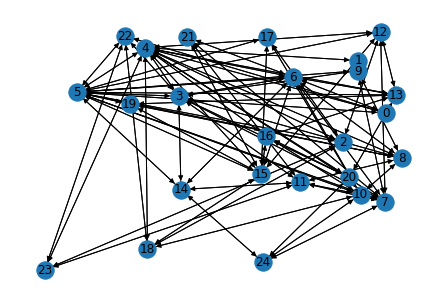

In [3]:
g = image_nertworkx()


node_pose = {}
for i in g.nodes():
    node_pose[i] = (random.uniform(1.0, 10.0),random.uniform(1.0, 10.0))

nx.draw(g,pos = node_pose, with_labels=True)
plt.savefig("images/original.jpg")
plt.show()

In [4]:
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
    
nx.set_edge_attributes(g, color, 'color')

In [5]:
dict_capa = {}
for i, j in g.edges:
    dict_capa[i, j] = dict_capa[j, i] = round(random.uniform(1.0, 20.0), 0)

nx.set_edge_attributes(g, dict_capa, 'capacity')

In [6]:
dict_used = {}
for i, j in g.edges:
    dict_used[i, j] = dict_used[j, i] = min(round(random.uniform(0.0, 15.0), 0),dict_capa[i, j])

nx.set_edge_attributes(g, dict_used, 'used')

In [7]:
dict_ratio = {}
for i, j in g.edges:
    dict_ratio[i, j] = dict_ratio[j, i] = dict_used[i, j]/dict_capa[i, j]

nx.set_edge_attributes(g, dict_ratio, 'ratio')

In [8]:
dict_delay = {}
for i, j in g.edges:
    dict_delay[i, j] = dict_delay[j, i] = round(random.uniform(1.0, 20.0), 2)

nx.set_edge_attributes(g, dict_delay, 'delay')

In [9]:
i,j = zip(*g.edges)
unique_i = np.unique(i)
list_ratio = []
for u_i in unique_i:
  temp_dict = {}
  for i, j in g.edges:
    if u_i==i:
      temp_dict["i"] = i
      temp_dict["j"] = j
      temp_dict["ratio"] = dict_ratio[i,j]
      list_ratio.append(*zip([list(temp_dict.values())[2]],[list(temp_dict.values())[0]],[list(temp_dict.values())[1]]))

list_ratio_i = (sorted(list_ratio, key=lambda element: (element[1],element[0])))
list_ratio_j = (sorted(list_ratio, key=lambda element: (element[2],element[0])))

In [21]:
dict_score = {}
score = 1
prev_ratio = -1
prev_i = 0
for ratio,i,j in list_ratio_i:
  if ratio != prev_ratio:
    score += 1
  prev_ratio = ratio
  if (prev_i != i):
    score = 0
    prev_i = i
  dict_score[i, j] = score

score = 1
prev_ratio = -1
prev_j = 0
for ratio,i,j in list_ratio_j:
  if ratio != prev_ratio:
    score += 1
  prev_ratio = ratio
  if (prev_j != j):
    score = 1
    prev_j = j
  dict_score[j, i] = score

nx.set_edge_attributes(g, dict_delay, 'score')

In [11]:
# instantiate
list_keys = ['shortest_path','min_delay','min_banwidth_sum','min_banwidth_square_sum','min_score','min_square_score']
dict_prob = {}
dict_prob = dict_prob.fromkeys(list_keys)

opti_path = {}
opti_path = dict([(key, []) for key in list_keys])

In [12]:
source = 7
target = 18

DEBUT CODE



shortest_path
Optimal
2.0
(4, 18) ,(7, 4) ,

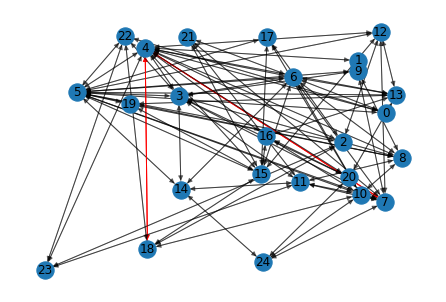


Press Enter to continue...


min_delay
Optimal
13.27
(4, 18) ,(7, 24) ,(13, 4) ,(20, 13) ,(24, 20) ,

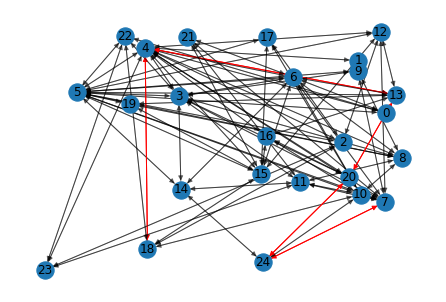


Press Enter to continue...


min_banwidth_sum
Optimal
0.7294117647058824
(7, 12) ,(12, 15) ,(15, 18) ,

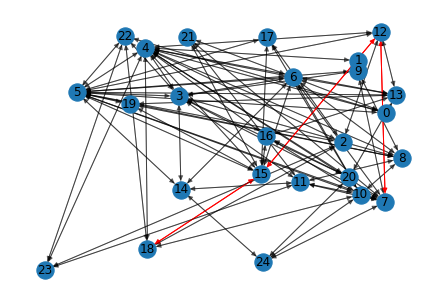


Press Enter to continue...


min_banwidth_square_sum
Optimal
9.646727497715267e-07
(7, 10) ,(10, 16) ,(13, 19) ,(15, 18) ,(16, 13) ,(19, 15) ,

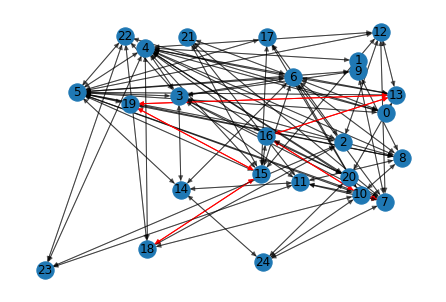


Press Enter to continue...


min_score
Optimal
8.0
(7, 12) ,(12, 15) ,(15, 18) ,

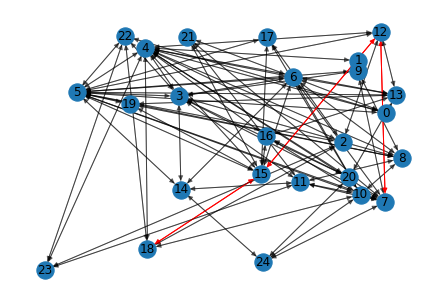


Press Enter to continue...


min_square_score
Optimal
22.0
(7, 10) ,(8, 19) ,(10, 8) ,(15, 18) ,(19, 15) ,

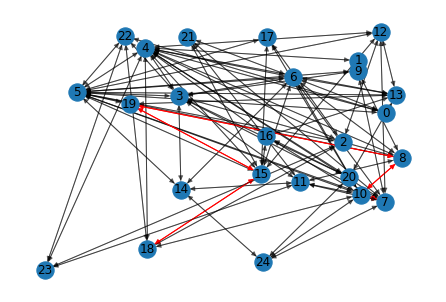


Press Enter to continue...


In [25]:
# binary variable to state a link is chosen or not
for keys,prob in dict_prob.items():
  prob = pulp.LpProblem("%s" % keys, pulp.LpMinimize)
  var_dict = {}
  for (i, j) in g.edges:
      x = pulp.LpVariable("%s_(%s_%s)" % (keys,i,j), cat=pulp.LpBinary)
      var_dict[i, j] = x
  bdw = 1

# objective function
  if keys == "shortest_path":
    prob += pulp.lpSum(var_dict[i, j] for i, j in g.edges), "Sum Node Count"
  elif keys == "min_delay":
    prob += pulp.lpSum([dict_delay[i, j] * var_dict[i, j] for i, j in g.edges]), "Sum delay"
  elif keys == "min_banwidth_sum":
    prob += pulp.lpSum([dict_ratio[i, j] * var_dict[i, j] for i, j in g.edges]), "Sum bandwidth ratio"
  elif keys == "min_banwidth_square_sum":
    prob += pulp.lpSum([dict_ratio[i, j] ** 2 * var_dict[i, j] for i, j in g.edges]), "Sum square bandwidth ratio"
  elif keys == "min_score":
    prob += pulp.lpSum([dict_score[i, j] * var_dict[i, j] for i, j in g.edges]), "Sum score"
  elif keys == "min_square_score":
    prob += pulp.lpSum([(dict_score[i, j] ** 2 * var_dict[i, j]) for i, j in g.edges]), "Sum square score"
    
# constraints
  for node in g.nodes:
      rhs = 0
      if node == source:
          rhs = -1
      elif node == target:
          rhs = 1
      prob += pulp.lpSum([var_dict[i, k] for i, k in g.edges if k == node]) - pulp.lpSum([var_dict[k, j] for k, j in g.edges if k == node]) == rhs

 # constraints on capacity
  for i,k in g.edges:
     prob += var_dict[i, k]*bdw + dict_used[i,k]  <= dict_capa[i,k]

  # solve
  prob.solve()
  print("\n\n" + str(keys))
  print(pulp.LpStatus[prob.status])
  print(pulp.value(prob.objective))
  for link in g.edges:
      if var_dict[link].value() == 1.0:
          print(link, end=" ,")
          opti_path[keys].append(link)
          g.edges[link[0],link[1]]['color'] = (1,0,0,1) 
            
  colors = nx.get_edge_attributes(g,'color').values()

  nx.draw(g, pos = node_pose, 
        edge_color=colors, 
        with_labels=True)

  plt.savefig("images/{}.jpg".format(keys))
  plt.show()

  color = {}
  for i, j in g.edges:
      color[i, j] = color[j, i] = (0,0,0,0.5)
      
  nx.set_edge_attributes(g, color, 'color')

  print("")
    
  input("Press Enter to continue...")
      

# Fin du code

## Début partie Debug

In [ ]:
for key,path in opti_path.items():
  res = [[ i for i, j in path ], 
       [ j for i, j in path ]] 
  un_res = list()
  for i in res[0]:
    un_res.append(i)
  for i in res[1]:
    if i not in un_res:
      un_res.append(i) 
  print(key)
  print(un_res)
  sg = g.subgraph(un_res)
  nx.draw(sg, with_labels=True)
  plt.show()
  input("Press Enter to continue...")


In [ ]:
path = [(1, 5) , (5, 151) , (6, 16) , (8, 74) , (16, 199) , (18, 97) , (74, 18) , (97, 6) , (151, 8)] 
dict_glob = {}
dict_glob["ratio"] = dict_ratio
dict_glob["delay"] = dict_delay
dict_glob["score"] = dict_score
for name,d in dict_glob.items():
  print('\n' + str(name))
  for key,values in d.items():
    if (key in path):
      print(key,end=' ')
      print(values,end=' ')

In [ ]:
print([dict_ratio[i, j] for i, j in g.edges])
print([var_dict[i, j] for i, j in g.edges])
print([dict_ratio[i, j] * var_dict[i, j] for i, j in g.edges])

In [ ]:
color.values()

In [ ]:
def image_nertworkx(nodes = 10, edges = 2, source = 0, taget = 39):
    g = nx.to_directed(nx.barabasi_albert_graph(nodes, edges))
    nx.draw(g, with_labels=True)
    plt.show()
    return g

In [ ]:
g = image_nertworkx()

In [ ]:
color = {}
for i, j in g.edges:
  color[i, j] = color[j, i] = (0,0,0,0.5)
color[0, 3] = color[3, 0] = (1,0,0,1)
nx.set_edge_attributes(g, color, 'color')

In [ ]:
g = image_nertworkx()
color = {}
for i, j in g.edges:
  color[i, j] = color[j, i] = (0,0,0,0.5)

nx.set_edge_attributes(g, color, 'color')

colors = nx.get_edge_attributes(g,'color').values()

pos = nx.spring_layout(g)
nx.draw(g, pos, 
        edge_color=colors, 
        with_labels=True,
        node_color='lightgreen')


In [ ]:
pos = nx.spring_layout(g)
color = {}
for i, j in g.edges:
    color[i, j] = color[j, i] = (0,0,0,0.5)
color[0, 3] = color[3, 0] = (1,0,0,1)
nx.set_edge_attributes(g, color, 'color')

nx.draw_networkx(g,pos,with_labels=True,edge_color=color) 

nx.draw_networkx_nodes(g,pos)
nx.draw_networkx_nodes(g,pos,g.nodes,node_size=100,label=True)
nx.draw_networkx_edges(g,pos,edge_color =color.values())
